
## SIMD Bitonic Sorting Network

This notebook presents the algorithm that evaluates a Bitonic Sorting Network using the _max_ function and SIMD computations. This approach allows to easily write the same algorithm using the CKKS primitives.

### Importing libraries

The *numpy* library will be useful as it will help us simulate SIMD computations. We also use *math* to compute logarithms and *matplotlib* to plot some numbers

In [166]:
import numpy as np
import math
import matplotlib.pyplot as plt

We will take advantage of Remez algorithm helper from the source file *remez_poly.py*

In [71]:
from remez_poly import *

Defining a class to handle Remez approximations

In [335]:
class Remez:
    def __init__(self, a, b, n, func):
        self.a = a
        self.b = b
        self.coeff = remez(func, n, a, b)[0]

    def eval(self, x):
        return numpy.polyval(self.coeff[::-1], x)
    
class Chebyshev:
    """
    Chebyshev(a, b, n, func)
    Given a function func, lower and upper limits of the interval [a,b],
    and maximum degree n, this class computes a Chebyshev approximation
    of the function.
    Method eval(x) yields the approximated function value.
    """
    def __init__(self, a, b, n, func):
        self.a = a
        self.b = b
        self.func = func

        bma = 0.5 * (b - a)
        bpa = 0.5 * (b + a)
        f = [func(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
        fac = 2.0 / n
        self.c = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n)
                  for k in range(n)]) for j in range(n)]

    def eval(self, x):
        a,b = self.a, self.b
        #assert(a <= x <= b)
        y = (2.0 * x - a - b) * (1.0 / (b - a))
        y2 = 2.0 * y
        (d, dd) = (self.c[-1], 0)             # Special case first step for efficiency
        for cj in self.c[-2:0:-1]:            # Clenshaw's recurrence
            (d, dd) = (y2 * d - dd + cj, d)
        return y * d - dd + 0.5 * self.c[0]   # Last step is different
    
def relu(x):
    return max(0, x)

poly_relu_remez = Remez(-1, 1, 32, relu)
poly_relu_cheby = Chebyshev(-1, 1, 247, relu)

## Defining primitive functions

This set of functions can be trivially written as CKKS homomorphic operations

In [336]:
def add(a, b):
    """
    Adds two arrays element-wise.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise sum of input arrays.
    """
    return np.add(a, b)

def add_many(values):
    """
    Sums up multiple arrays contained in the values list.

    Parameters:
    values (list of array-like): List containing arrays to be summed.

    Returns:
    numpy.ndarray: Sum of all arrays in the values list.
    """
    res = np.zeros(len(values[0]), dtype=int)
    for value in values:
        res = add(res, value)
    return res

def sub(a, b):
    """
    Subtracts one array from another element-wise.

    Parameters:
    a (array-like): The array to be subtracted from.
    b (array-like): The array to subtract.

    Returns:
    numpy.ndarray: Element-wise difference of the two input arrays.
    """
    return np.add(a, -b)

def mul(a, b):
    """
    Multiplies two arrays element-wise.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise product of input arrays.
    """
    return np.multiply(a, b)

def mask(a, index):
    """
    Masks elements of array a at the specified index with 1 and multiplies with the array.

    Parameters:
    a (array-like): The input array.
    index (int): Index to be masked.

    Returns:
    numpy.ndarray: Array with specified index masked with 1.
    """
    mask_vector = np.zeros(len(a), dtype=int)
    mask_vector[index] = 1
    return mul(a, mask_vector)

def rot(a, index):
    """
    Rotates the array to the left by the specified number of positions.

    Parameters:
    a (array-like): The input array.
    index (int): Number of positions to rotate the array to the left.

    Returns:
    numpy.ndarray: Array rotated to the left by the specified number of positions.
    """
    return np.roll(a, -index)

def f_min(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    ans = []
    for i in range(len(a)):
        ans.append(min(a[i], b[i]))
    return np.array(ans)

def f_min_remez(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    ans = []
    for i in range(len(a)):
        ans.append(a[i] - poly_relu_remez.eval(a[i] - b[i]))
    return np.array(ans)

def f_min_cheby(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    return sub(a, np.vectorize(poly_relu_cheby.eval)(sub(a, b)))

Now we define the _swap_ function that will heavily be used throughout the evaluation of the Sorting Network

In [337]:
def swap_simd(a, delta, r = 0, s = 0, poly = True):    
    """
    Computes a parallel evaluation of a Sorting Network

    Parameters:
    a (array-like): Input array
    delta (int): The value of delta. In a sorting network, it specifies the "length of the arrows".
    r (int): The current round of the sorting network
    s (int): The current stage of the sorting network

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    rot_positive = rot(a, delta)
    rot_negative = rot(a, -delta)
    
    # This is the evaluation of the non-linear function
    
    if poly:
        f = f_min_cheby(a, rot_positive)
    else:
        f = f_min(a, rot_positive)
            
    m1 = f
    m2 = sub(add(a, rot_negative), rot(f, -delta))
    m3 = sub(add(a, rot_positive), f)
    m4 = rot(f, -delta)
    
    masks = generate_masks(len(a), r, s)
    
    return add_many([mul(m1, masks[0]), 
                     mul(m2, masks[1]),
                     mul(m3, masks[2]),
                     mul(m4, masks[3])])

In [338]:
def generate_masks(length, r, s):
    """
    Da commentare
    """
    mask_1 = []
    mask_2 = []
    mask_3 = []
    mask_4 = []
    
    i = 0  
    
    while (i < length / (2 ** (r + 2))):
        
        for times in range(2 ** s):
            for j in range(2 ** r):
                # How many times do we consider m_1

                mask_1.append(1)
                mask_2.append(0)
                mask_3.append(0)
                mask_4.append(0)

            for j in range(2 ** r):
                # How many times do we consider m_2

                mask_1.append(0)
                mask_2.append(1)
                mask_3.append(0)
                mask_4.append(0)
        
        if (i + 1) * 2 ** (s + r + 1) >= length:
            break
            
        for times in range(2 ** s):
            for j in range(2 ** (r)):
                mask_1.append(0)
                mask_2.append(0)
                mask_3.append(1)
                mask_4.append(0)
                
            for j in range(2 ** r):
                mask_1.append(0)
                mask_2.append(0)
                mask_3.append(0)
                mask_4.append(1)
        
            
        if (i + 1) * 2 ** (s + r + 2) >= length:
            break
            
        i += 1
    
    return [mask_1, mask_2, mask_3, mask_4]

### Evaluating a Network

We sample a vector of $2^{6} = 64$ elements

In [339]:
n = 2 ** 6

a = np.arange(n) / n
np.random.shuffle(a)

vec = np.copy(a)
print(vec)

[0.546875 0.078125 0.75     0.59375  0.046875 0.03125  0.515625 0.625
 0.484375 0.25     0.359375 0.578125 0.328125 0.90625  0.40625  0.375
 0.796875 0.09375  0.828125 0.421875 0.84375  0.734375 0.34375  0.234375
 0.78125  0.171875 0.953125 0.125    0.296875 0.703125 0.203125 0.15625
 0.671875 0.390625 0.5625   0.859375 0.0625   0.265625 0.65625  0.1875
 0.015625 0.71875  0.4375   0.46875  0.140625 0.5      0.28125  0.96875
 0.21875  0.921875 0.53125  0.109375 0.609375 0.3125   0.       0.8125
 0.765625 0.9375   0.640625 0.890625 0.875    0.984375 0.6875   0.453125]


Now we evaluate it using SIMD computations, in particular we will just use the _swap_simd_ function

In [340]:
for i in range(int(math.log2(n))):
    for j in range(i + 1): 
        delta = 2 ** (i - j)
        s = i - j
        r = j
        vec = swap_simd(vec, delta, s, r, poly = True)  
vec

array([-8.84250739e-04,  1.61827647e-02,  2.79167794e-02,  5.00839830e-02,
        6.24713227e-02,  7.79290506e-02,  9.45372919e-02,  1.09570205e-01,
        1.25160542e-01,  1.40214736e-01,  1.53449441e-01,  1.74748906e-01,
        1.88031967e-01,  2.02592539e-01,  2.18258944e-01,  2.34307718e-01,
        2.50879076e-01,  2.65516071e-01,  2.81288299e-01,  2.96972058e-01,
        3.12871640e-01,  3.28608563e-01,  3.43923641e-01,  3.57210703e-01,
        3.76551121e-01,  3.89118246e-01,  4.05045420e-01,  4.22753259e-01,
        4.38435663e-01,  4.54045795e-01,  4.68508195e-01,  4.84341858e-01,
        4.99336834e-01,  5.16863865e-01,  5.31115173e-01,  5.46375467e-01,
        5.62260477e-01,  5.77540227e-01,  5.95558912e-01,  6.09268597e-01,
        6.24812927e-01,  6.40584141e-01,  6.56400170e-01,  6.71415675e-01,
        6.87808600e-01,  7.02425774e-01,  7.18455596e-01,  7.34269605e-01,
        7.50019541e-01,  7.64992174e-01,  7.79771084e-01,  7.98705868e-01,
        8.13397860e-01,  

In [341]:
a.sort()
a

array([0.      , 0.015625, 0.03125 , 0.046875, 0.0625  , 0.078125,
       0.09375 , 0.109375, 0.125   , 0.140625, 0.15625 , 0.171875,
       0.1875  , 0.203125, 0.21875 , 0.234375, 0.25    , 0.265625,
       0.28125 , 0.296875, 0.3125  , 0.328125, 0.34375 , 0.359375,
       0.375   , 0.390625, 0.40625 , 0.421875, 0.4375  , 0.453125,
       0.46875 , 0.484375, 0.5     , 0.515625, 0.53125 , 0.546875,
       0.5625  , 0.578125, 0.59375 , 0.609375, 0.625   , 0.640625,
       0.65625 , 0.671875, 0.6875  , 0.703125, 0.71875 , 0.734375,
       0.75    , 0.765625, 0.78125 , 0.796875, 0.8125  , 0.828125,
       0.84375 , 0.859375, 0.875   , 0.890625, 0.90625 , 0.921875,
       0.9375  , 0.953125, 0.96875 , 0.984375])

Computing precision bits

In [342]:
print("Precision bits: {}".format(round(-math.log2(max(sub(a, vec))), 2)))

Precision bits: 8.23


In [343]:
print("Real sorted: {}\nPoly sorted: {}".format(a * n, vec * n))

Real sorted: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63.]
Poly sorted: [-5.65920473e-02  1.03569694e+00  1.78667388e+00  3.20537491e+00
  3.99816465e+00  4.98745924e+00  6.05038668e+00  7.01249314e+00
  8.01027468e+00  8.97374312e+00  9.82076424e+00  1.11839300e+01
  1.20340459e+01  1.29659225e+01  1.39685724e+01  1.49956939e+01
  1.60562609e+01  1.69930286e+01  1.80024511e+01  1.90062117e+01
  2.00237850e+01  2.10309480e+01  2.20111130e+01  2.28614850e+01
  2.40992717e+01  2.49035678e+01  2.59229069e+01  2.70562086e+01
  2.80598824e+01  2.90589309e+01  2.99845245e+01  3.09978789e+01
  3.19575574e+01  3.30792874e+01  3.39913711e+01  3.49680299e+01
  3.59846705e+01  3.69625745e+01  3.81157704e+01  3.89931902e+01
  3.99880274e+01  4.09973850e+01  4.20096109e+01  4.29706032e+0

Distribution of errors

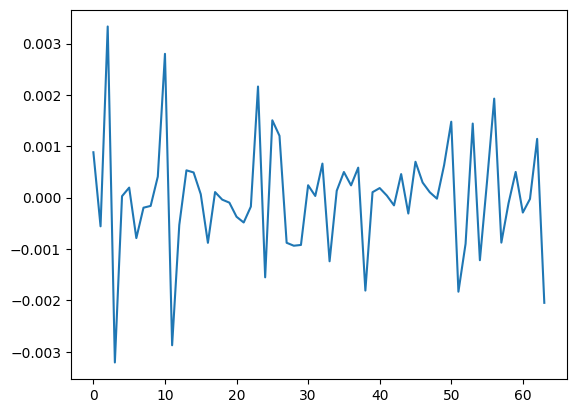

In [344]:
plt.plot(sub(a, vec), label="Real")